# Notebook expérimental
## Mars Express Data Driven Digital Twin
---

In [1]:
## Preprocessing
from sklearn.preprocessing import StandardScaler
from preprocessing import *

## Modeling
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras import models, layers, initializers
from joblib import dump, load


In [2]:
train, test = import_data()

In [3]:
train.shape

(49464, 95)

array([<AxesSubplot:xlabel='ut_ms'>, <AxesSubplot:xlabel='ut_ms'>,
       <AxesSubplot:xlabel='ut_ms'>, <AxesSubplot:xlabel='ut_ms'>,
       <AxesSubplot:xlabel='ut_ms'>], dtype=object)

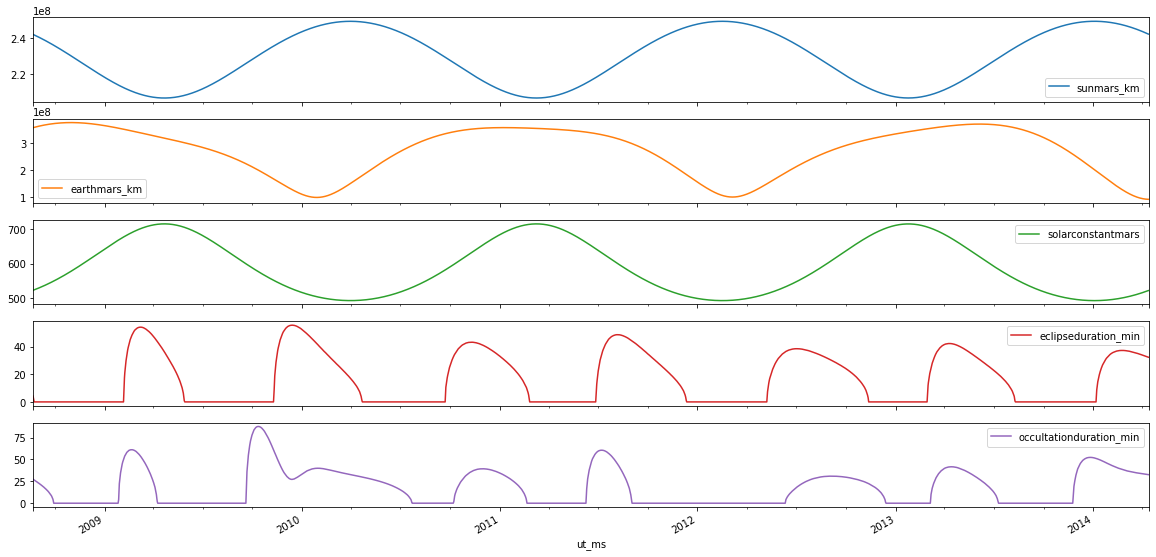

In [7]:
data = train[['sunmars_km', "earthmars_km", "solarconstantmars", "eclipseduration_min", "occultationduration_min"]]
data.plot(subplots=True, figsize=(20,10))

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [8]:
data

,sunmars_km,earthmars_km,solarconstantmars,eclipseduration_min,occultationduration_min
ut_ms,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,522.263999,4.166667,27.400000
2008-08-22 01:00:00,2.419331e+08,3.557789e+08,522.288980,4.067361,27.380556
2008-08-22 02:00:00,2.419273e+08,3.558017e+08,522.313961,3.968056,27.361111
2008-08-22 03:00:00,2.419216e+08,3.558245e+08,522.338941,3.868750,27.341667
2008-08-22 04:00:00,2.419158e+08,3.558473e+08,522.363922,3.769444,27.322222
...,...,...,...,...,...
2014-04-13 19:00:00,2.420765e+08,9.242161e+07,521.670476,32.216667,32.633333
2014-04-13 20:00:00,2.420765e+08,9.242161e+07,521.670476,32.216667,32.633333
2014-04-13 21:00:00,2.420765e+08,9.242161e+07,521.670476,32.216667,32.633333


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49464 entries, 2008-08-22 00:00:00 to 2014-04-13 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sunmars_km               49464 non-null  float64
 1   earthmars_km             49464 non-null  float64
 2   solarconstantmars        49464 non-null  float64
 3   eclipseduration_min      49464 non-null  float64
 4   occultationduration_min  49464 non-null  float64
dtypes: float64(5)
memory usage: 2.3 MB


In [34]:
n_days = 100# We use 10 days windows to train the LSTM 
n_out = 1
n_features = data.shape[1]
reframed = series_to_supervised(data, n_days, n_out)
# reframed.drop(reframed.columns[[-2,-3,-4,-5]], axis=1, inplace=True)
reframed.shape

(49364, 505)

In [35]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49364 entries, 2008-08-26 04:00:00 to 2014-04-13 23:00:00
Freq: H
Columns: 505 entries, var1(t-100) to var5(t)
dtypes: float64(505)
memory usage: 190.6 MB


In [36]:
n_obs = n_features * n_days
values = reframed.values
train = values[:int(values.shape[0]*0.8), :] # 80% TRAIN / 20% TEST
test = values[int(values.shape[0]*0.8):, :]
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print("Shape : (samples, timesteps, features)\n")
print("Train X shape :",train_X.shape, "\nTrain y shape :",train_y.shape)
print("Test X shape :",test_X.shape, "\nTest y shape :",test_y.shape)


Shape : (samples, timesteps, features)

Train X shape : (39491, 100, 5) 
Train y shape : (39491,)
Test X shape : (9873, 100, 5) 
Test y shape : (9873,)


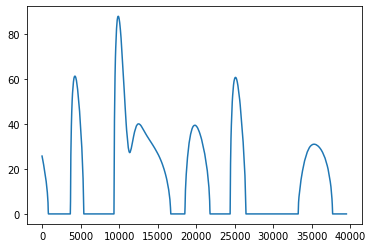

In [37]:
plt.plot(train_y)

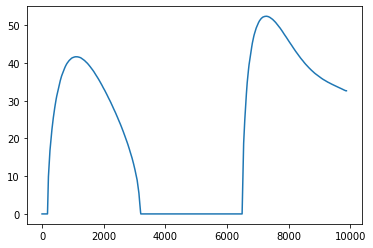

In [38]:
plt.plot(test_y)

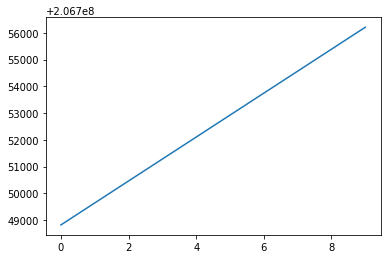

In [24]:
plt.plot(train_X[39000,:,0])

Epoch 1/10
1235/1235 - 48s - loss: 622.2525 - val_loss: 736.5832
Epoch 2/10
1235/1235 - 69s - loss: 528.2304 - val_loss: 641.5457
Epoch 3/10
1235/1235 - 76s - loss: 488.0237 - val_loss: 586.5870
Epoch 4/10
1235/1235 - 76s - loss: 468.3658 - val_loss: 548.5748
Epoch 5/10
1235/1235 - 84s - loss: 456.2593 - val_loss: 519.3110
Epoch 6/10
1235/1235 - 79s - loss: 447.6675 - val_loss: 495.7027
Epoch 7/10
1235/1235 - 48s - loss: 441.2191 - val_loss: 476.2771
Epoch 8/10
1235/1235 - 48s - loss: 436.2784 - val_loss: 460.1369
Epoch 9/10
1235/1235 - 53s - loss: 432.4548 - val_loss: 446.6425
Epoch 10/10
1235/1235 - 59s - loss: 429.4677 - val_loss: 435.3048
INFO:tensorflow:Assets written to: models/lstm_(100x1)_03-12-2020(11:05:57).model/assets


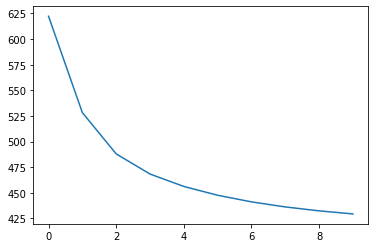

In [39]:
def save_model(trained_model, model_type, keras, params = ''):
    timestamp = d.datetime.now().strftime("%d-%m-%Y(%H:%M:%S)")
    if keras:
        trained_model.save(f'models/{model_type}_{params}{timestamp}.model')
    else :
        dump(trained_model, f"models/{model_type}_{params}{timestamp}.model")


n_units = 50
epochs = 10
model = models.Sequential()
model.add(layers.LSTM(n_units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=2, shuffle=False)
params = f"({n_days}x{n_out})_"

save_model(model, "lstm", True, params)
plt.plot(history.history["loss"])
plt.show()


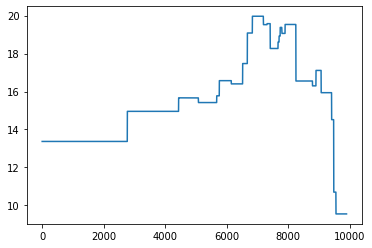

In [29]:
yhat = model.predict(test_X)
plt.plot(yhat)
#     test_X = test_X.reshape((test_X.shape[0], n_obs))
#     inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
#     inv_yhat = scaler.inverse_transform(inv_yhat)
#     test_y = test_y.reshape((len(test_y), 1))
#     inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
#     inv_y = scaler.inverse_transform(inv_y)

In [61]:
def analysis_lstm(model, test_X, test_y):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_obs))
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    
    ## Calcul du NRMSE
    y = inv_y[:,0]
    pred = inv_yhat[:,0]

    squared_difference_sum = 0
    for i in range(len(pred)):
        
        squared_difference = (pred[i] -  y[i])**2 # NSE, RMSE, NRMSE
        squared_difference_sum += squared_difference 

    NRMSE = np.sqrt(squared_difference_sum / len(pred)) / np.mean(y)

    print("NRMSE : ",NRMSE)
    
    plt.plot(y, label='Valeur réelle')
    plt.plot(pred, label="Prédictions sur echantillon test (20%)")
    plt.title("Hydrogramme du reach 1 (réel vs prédit)")
    plt.legend()
    plt.show()

NRMSE :  0.0960704398625692


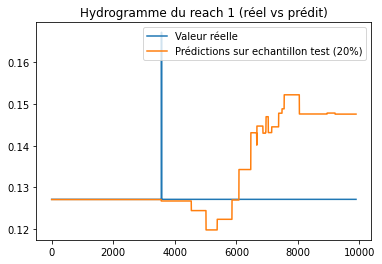

In [62]:
analysis_lstm(model, test_X, test_y )

In [39]:
scaler = StandardScaler()
train = scaler.fit_transform(train.values)


In [36]:
train

array([[0.13358171, 0.00155215, 0.17543574, ..., 0.        , 0.        ,
        0.        ],
       [0.21700089, 0.00149758, 0.17588812, ..., 0.        , 0.        ,
        0.        ],
       [0.15592227, 0.00150259, 0.17538913, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11033096, 0.00152606, 0.17576202, ..., 0.        , 0.        ,
        0.        ],
       [0.11463794, 0.00155811, 0.17565298, ..., 0.        , 0.        ,
        0.        ],
       [0.18308042, 0.0015365 , 0.17534252, ..., 0.        , 0.        ,
        0.        ]])